<a href="https://colab.research.google.com/github/arbelkatzir/final_project_DS/blob/main/PART2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project

##### What's new:
* Changed  'fileds.components' to 'component_names' column name.
* Changed 'fields.Sub-Components' to 'sub_component_values' column name.
* Changed the numeric column in the list from 'key' to 'numeric_key' column name.
* Added column fields.Severity .value to 'data' df as category column.
* Added columns to df: 'fields.Time in Status', 'fields.status.name'
* Added another df called 'status_df' with each row how much in each status_id in minutes.

# Imports

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt  # Corrected spelling
import seaborn as sns  # For enhanced data visualization
from scipy import stats  # For statistical tests
import warnings  # To suppress warnings during EDA
import re
warnings.filterwarnings("ignore")  # Optional, to make output cleaner
from bs4 import BeautifulSoup
import ast
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Load Data

## data for analysis

In [ ]:
df_raw = pd.read_excel("data_for_analysis.xlsx")
df_raw.head(3)

,key,fields.issuelinks,fields.Analysis,fields.Target end,fields.Target start,fields.subtasks,fields.votes.votes,fields.issuetype.name,fields.Development,fields.Detected In Build,...,fields.Root Cause Type .value,fields.Root Cause Type .child.value,fields.Escaped Defect Cause Type .value,fields.Should Have Been Found In .value,fields.Escaped Defect Cause Type .child.value,fields.Introduced In .releaseDate,key_y,fields.comment.maxResults,fields.Status .self,fields.Status .value
0,NCCFM-10561,[],NaN,NaN,NaN,[],0,Issue,{summaryBean=com.atlassian.jira.plugin.devstat...,CHF_24_7_I171,...,NaN,NaN,NaN,NaN,NaN,NaN,NCCFM-10561,1,NaN,NaN
1,NCCFM-10560,[],NaN,NaN,NaN,[],0,Issue,{summaryBean=com.atlassian.jira.plugin.devstat...,SPS_24_3_I1671,...,NaN,NaN,NaN,NaN,NaN,NaN,NCCFM-10560,1,NaN,NaN
2,NCCFM-10559,[],NaN,NaN,NaN,[],0,Issue,{summaryBean=com.atlassian.jira.plugin.devstat...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NCCFM-10559,0,NaN,NaN


In [ ]:
# Replace 'Complete' and 'Done' statuses with 'Closed'
df_raw['fields.status.name'] = df_raw['fields.status.name'].replace(['Completed', 'Done'], 'Closed')

# Replace the corresponding status IDs for 'Complete' and 'Done' to a single value (e.g., 99999 for 'Closed')
df_raw['fields.status.id'] = df_raw.apply(
    lambda x: 99999 if x['fields.status.name'] == 'Closed' else x['fields.status.id'], axis=1
)

# Merge 'Needless' with 'Obsolete' by replacing 'Needless' with 'Obsolete'
df_raw['fields.status.name'] = df_raw['fields.status.name'].replace('Needless', 'Obsolete')

# Replace the corresponding status IDs for 'Needless' to a single value (e.g., 88888 for 'Obsolete')
df_raw['fields.status.id'] = df_raw.apply(
    lambda x: 88888 if x['fields.status.name'] == 'Obsolete' else x['fields.status.id'], axis=1
)

In [ ]:
df_raw = df_raw[ ~ df_raw['fields.Detailed Status .value'].isin(['Created as Support Request', 'Created as Fault/Converted to Support Request', 'Created as Support Request - Multiple Item Type conversions',''])]

## changlog

In [ ]:
cl_df = pd.read_excel('changlog.xlsx')
cl_df.head()

BadZipFile: File is not a zip file

In [ ]:
# Replace 'Complete' and 'Done' statuses with 'Closed'
cl_df['NEWSTRING'] = cl_df['NEWSTRING'].replace(['Complete', 'Done'], 'Closed')

# Merge 'Needless' with 'Obsolete' by replacing 'Needless' with 'Obsolete'
cl_df['NEWSTRING'] = cl_df['NEWSTRING'].replace('Needless', 'Obsolete')

# Display the updated DataFrame
print(cl_df['NEWSTRING'].value_counts())

In [ ]:
# add fields.Detailed Status .value to cl_df and exclude defects that is not Faults
cl_df = cl_df.merge(df_raw[['key', 'fields.Detailed Status .value']], how='inner', left_on='Issue_Key', right_on='key')
cl_df.drop('key', axis=1, inplace=True)

In [ ]:
cl_df.head()

## comments

In [ ]:
comments_data = pd.read_excel('Comments.xlsx')
comments_data.head()

# prepare data

In [ ]:
df = pd.DataFrame({})

In [ ]:
cols = ['fields.Time in Status ','fields.timeestimate','fields.status.name','fields.status.id','fields.status.statusCategory.id']

In [ ]:
df['numeric_key'] = df_raw['key'].str.split('-').str[1].astype(int)
df['fields.resolutiondate'] = pd.to_datetime(df_raw['fields.resolutiondate'], utc=True)
df['fields.description'] = df_raw['fields.description'].astype(str)
df['renderedFields.resolutiondate'] = pd.to_datetime(df_raw['renderedFields.resolutiondate'], utc=True)
df['fields.Team .id'] = df_raw['fields.Team .id'].fillna(0).astype(int) # Fill missing values with 0 (or any default value)
df['fields.Team .name'] = df_raw['fields.Team .name'].astype(str)
df['fields.resolution.id'] = df_raw['fields.resolution.id'].fillna(0).astype(int) # Fill missing values with 0 (or any default value)
df['fields.resolution.description'] = df_raw['fields.resolution.description'].astype(str)
df['fields.resolution.name'] = df_raw['fields.resolution.name'].astype('category')
df['fields.Root Cause Type .value'] = df_raw['fields.Root Cause Type .value'].astype('category')
df['fields.Root Cause Type .child.value'] = df_raw['fields.Root Cause Type .child.value'].astype('category')
df['fields.Severity.value'] = df_raw['fields.Severity .value'].astype('category')

In [ ]:
df['fields.Time in Status'] = df_raw['fields.Time in Status ']
df['fields.status.name'] = df_raw['fields.status.name']

In [ ]:
df['fields.Resolution Details'] = df_raw['fields.Resolution Details'].astype(str)
df['fields.Resolution Details'] = df_raw['fields.Resolution Details'].replace(['-', ''], None)

In [ ]:
# Function to extract component names
def extract_names(components):
    if pd.isna(components) or components == "[]":  # Handle missing or empty lists
        return []
    try:
        # Convert string representation of list to actual list
        components_list = ast.literal_eval(components)
        return [comp['name'] for comp in components_list]  # Extract 'name' field
    except (ValueError, KeyError, SyntaxError):
        return []  # Return empty list for invalid formats

# Apply function to extract names
df['component_names'] = df_raw['fields.components'].apply(extract_names)

In [ ]:
# Function to extract 'value' fields
def extract_values(sub_components):
    if pd.isna(sub_components) or sub_components == "[]":  # Handle missing or empty lists
        return []
    try:
        # Convert string representation of list to actual list
        sub_components_list = ast.literal_eval(sub_components)
        return [comp['value'] for comp in sub_components_list]  # Extract 'value' field
    except (ValueError, KeyError, SyntaxError):
        return []  # Return empty list for invalid formats

# Apply function to extract values
df['sub_component_values'] = df_raw['fields.Sub-Components'].apply(extract_values)

In [ ]:
# Function to clean HTML content
def clean_html(raw_html):
    if pd.isna(raw_html):  # Check if value is NaN or None
        return None  # Return None for missing values
    soup = BeautifulSoup(raw_html, 'html.parser')
    return soup.get_text(separator='\n')  # Extract text and separate with newlines for readability

# Apply the function to the 'renderedFields.description' column
df['description_cleaned'] = df_raw['renderedFields.description'].apply(clean_html)

In [ ]:
# Convert the 'CREATED' column to datetime format
cl_df['CREATED'] = pd.to_datetime(cl_df['CREATED'])

NameError: name 'cl_df' is not defined

# EDA - Part 1

## basic visualiztion

In [ ]:
df.head()
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7544 entries, 0 to 10268
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype              
---  ------                               --------------  -----              
 0   numeric_key                          7544 non-null   int32              
 1   fields.resolutiondate                7117 non-null   datetime64[ns, UTC]
 2   fields.description                   7544 non-null   object             
 3   renderedFields.resolutiondate        7117 non-null   datetime64[ns, UTC]
 4   fields.Team .id                      7544 non-null   int32              
 5   fields.Team .name                    7544 non-null   object             
 6   fields.resolution.id                 7544 non-null   int32              
 7   fields.resolution.description        7544 non-null   object             
 8   fields.resolution.name               7117 non-null   category           
 9   fields.Root Cause Type .value     

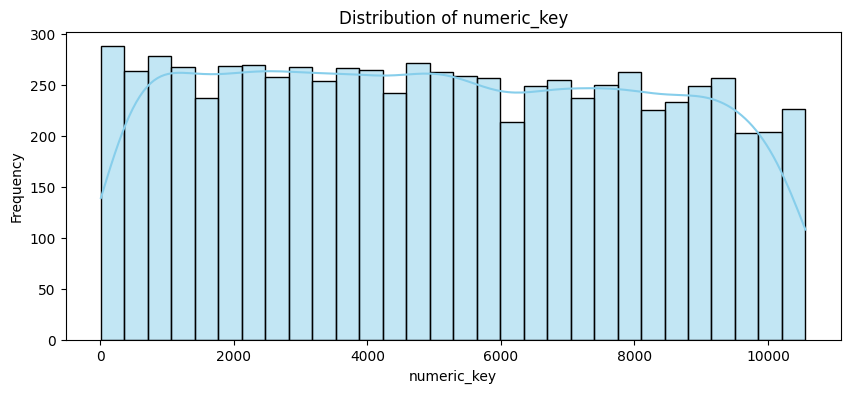

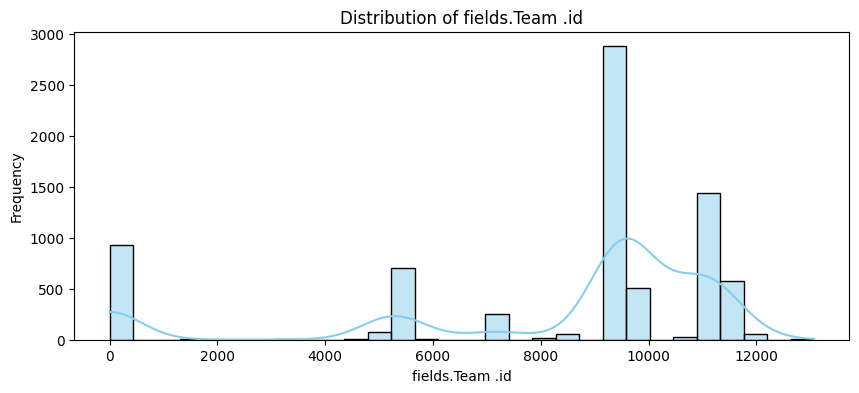

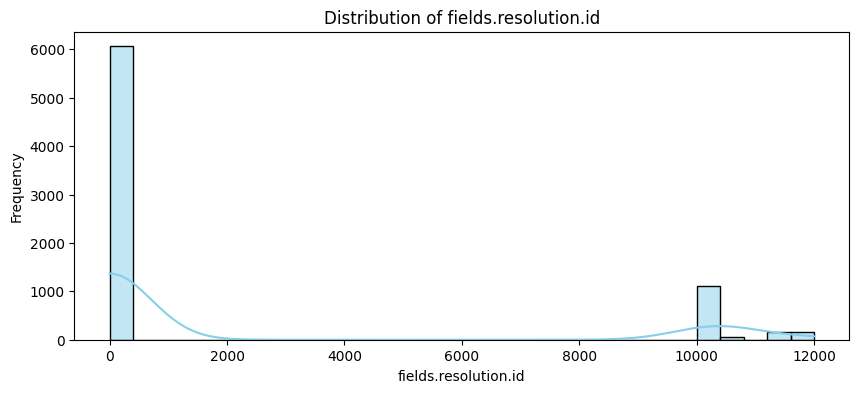

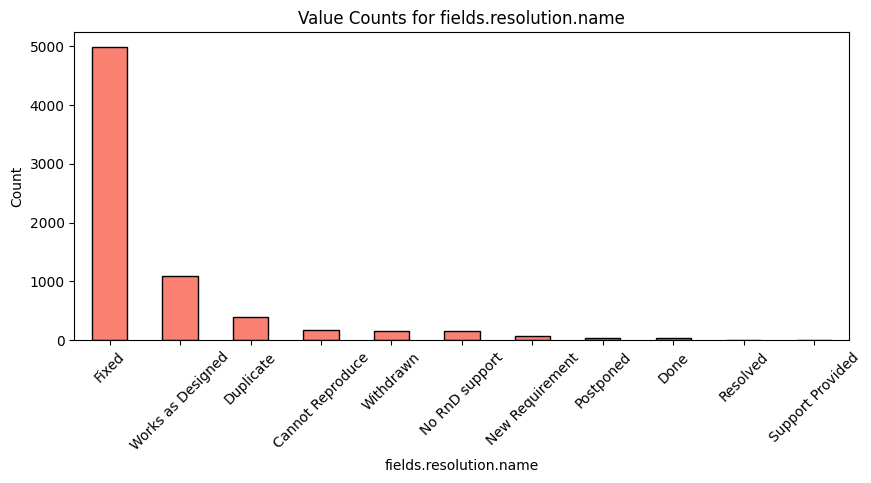

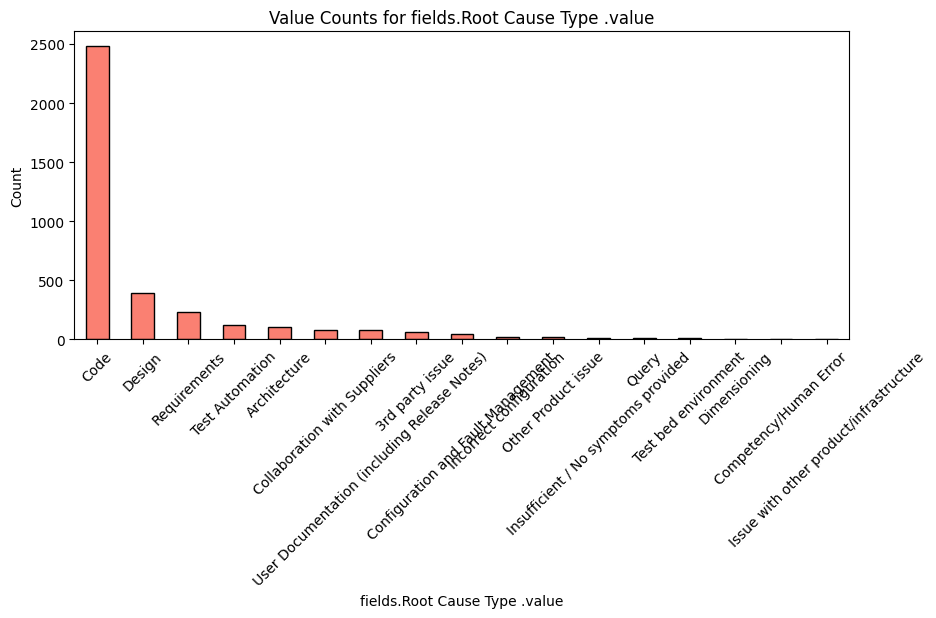

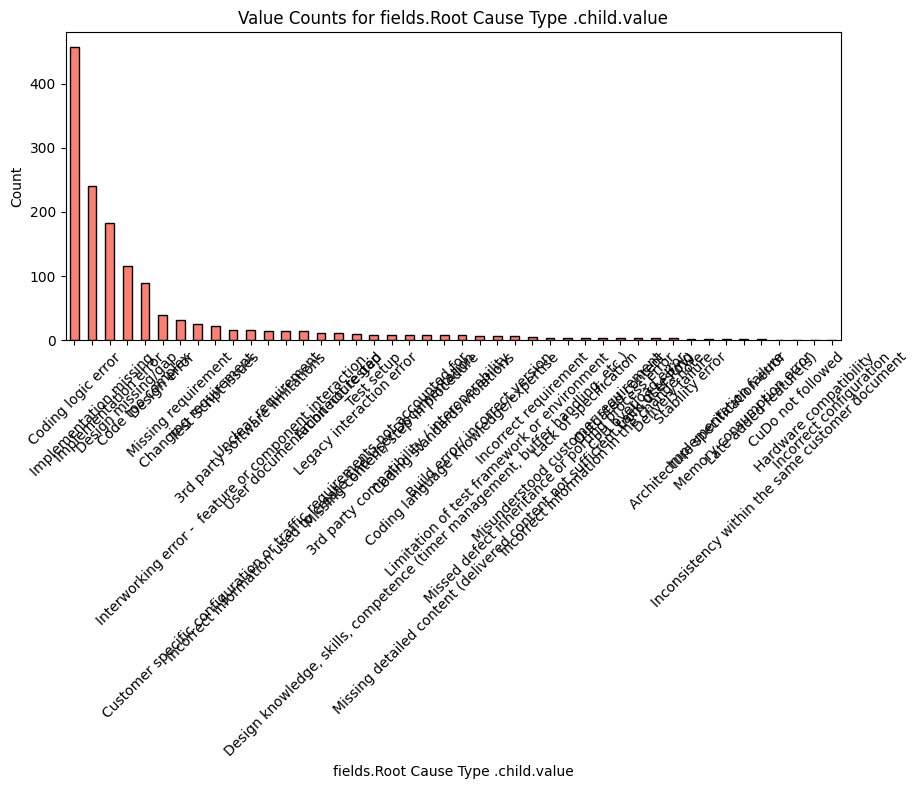

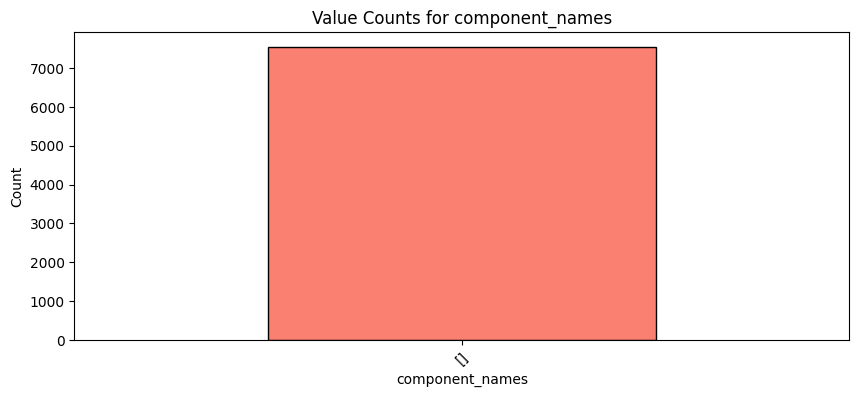

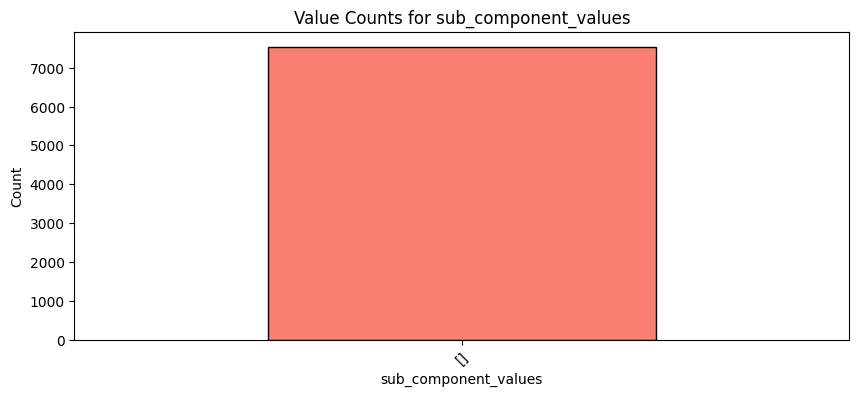

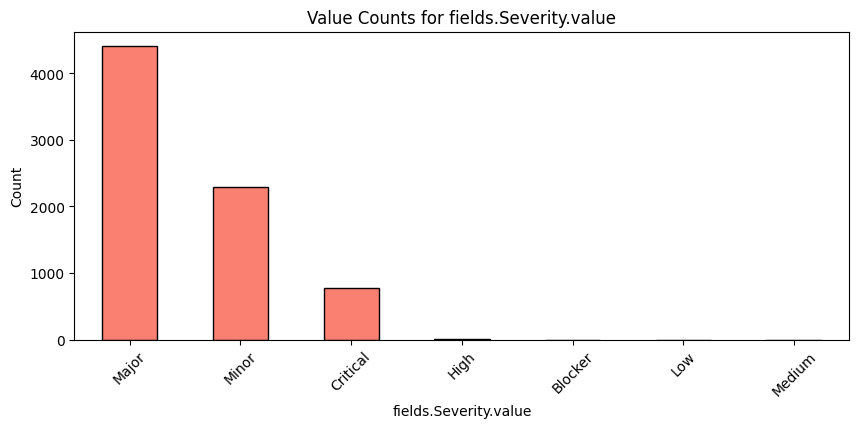

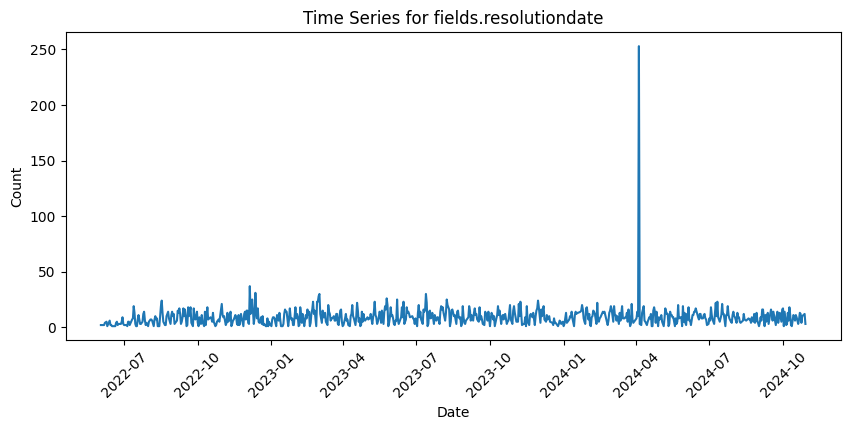

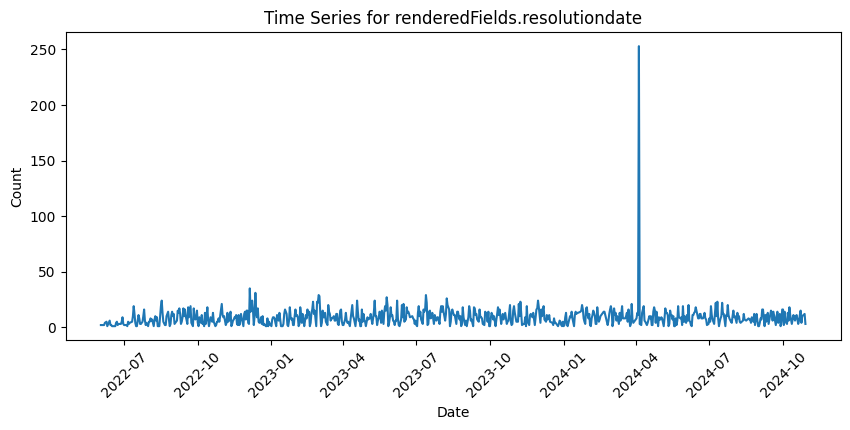

In [ ]:
# Function to visualize based on data type
def visualize_data(df):
    # Filter out unwanted columns (e.g., strings and columns with "None" status)
    numeric_cols = ['numeric_key', 'fields.Team .id', 'fields.resolution.id']#changed the numeric column in the list from 'key' to 'numeric_key'
    categorical_cols = [
        'fields.resolution.name',
        'fields.Root Cause Type .value',
        'fields.Root Cause Type .child.value',
        'component_names',#change fileds.components to component_names
        'sub_component_values',# change fields.Sub-Components to sub_component_values
        'fields.Severity.value'
    ]
    datetime_cols = ['fields.resolutiondate', 'renderedFields.resolutiondate']

    # Visualize numeric columns
    for col in numeric_cols:
        plt.figure(figsize=(10, 4))
        sns.histplot(df[col], kde=True, bins=30, color='skyblue', edgecolor='black')
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()

    # Visualize categorical columns
    for col in categorical_cols:
        plt.figure(figsize=(10, 4))
        df[col].value_counts().plot(kind='bar', color='salmon', edgecolor='black')
        plt.title(f'Value Counts for {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()

    # Visualize datetime columns
    for col in datetime_cols:
        plt.figure(figsize=(10, 4))
        if df[col].notnull().sum() > 0:
            df[col].dt.date.value_counts().sort_index().plot()
            plt.title(f'Time Series for {col}')
            plt.xlabel('Date')
            plt.ylabel('Count')
            plt.xticks(rotation=45)
        else:
            print(f"No non-null values to plot in {col}")
        plt.show()

# Call the visualization function on the dataset
visualize_data(df)

## Severity distribuution

In [ ]:
categories_to_include = ['Major', 'Minor', 'Critical']
filtered_df = df[df['fields.Severity.value'].isin(categories_to_include)]
severity_counts = filtered_df['fields.Severity.value'].value_counts()

for category in categories_to_include:
    count = severity_counts.get(category, 0)  # Default to 0 if the category doesn't exist
    print(f"{category}: {count}")

# categories = filtered_df['fields.Severity.value'].unique()
# print("Categories in 'Severity' column:")
# print(categories)

Major: 4407
Minor: 2285
Critical: 769


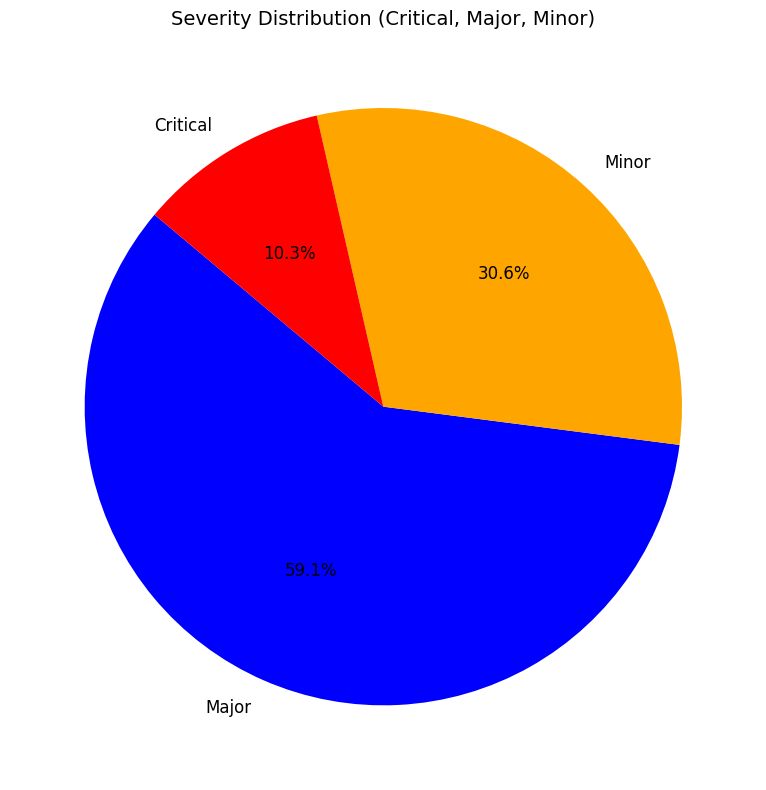

In [ ]:
# Extract only relevant categories for the pie chart
categories_to_include = ["Major", "Minor", "Critical"]
filtered_counts = {key: severity_counts[key] for key in categories_to_include}

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    filtered_counts.values(),
    labels=filtered_counts.keys(),
    autopct='%1.1f%%',
    startangle=140,
    colors=['blue', 'orange', 'red'],
    textprops={'fontsize': 12}
)
plt.title('Severity Distribution (Critical, Major, Minor)', fontsize=14)
plt.tight_layout()

# Show the chart
plt.show()

Major: 6272
Minor: 2884
Critical: 1028

## Status change distribution

In [ ]:
df = df.reset_index(drop=True)
df.head(10)

,numeric_key,fields.resolutiondate,fields.description,renderedFields.resolutiondate,fields.Team .id,fields.Team .name,fields.resolution.id,fields.resolution.description,fields.resolution.name,fields.Root Cause Type .value,fields.Root Cause Type .child.value,fields.Severity.value,fields.Time in Status,fields.status.name,fields.Resolution Details,component_names,sub_component_values,description_cleaned
0,10561,NaT,ISU testing from 24.3I189 to 24.7I171.There ar...,NaT,0,nan,0,nan,NaN,NaN,NaN,Major,NaN,Open,NaN,[],[],ISU testing from 24.3I189 to 24.7I171.\nThere ...
1,10557,NaT,Type of Issue : < ME / EME / RCA / Analysis > ...,NaT,0,nan,0,nan,NaN,NaN,NaN,Major,NaN,Backlog,NaN,[],[],Type of Issue : < ME / EME / RCA / Analysis >\...
2,10556,NaT,Problem Statement: Daily service polling Inter...,NaT,9528,SPS Charging 8,0,nan,NaN,NaN,NaN,Minor,NaN,In Progress,NaN,[],[],Problem Statement: Daily service polling Inter...
3,10555,NaT,Type of Issue : < ME / EME / RCA / Analysis > ...,NaT,11350,SPS Charging CCoE 3,0,nan,NaN,NaN,NaN,Minor,NaN,Backlog,NaN,[],[],Type of Issue : < ME / EME / RCA / Analysis >\...
4,10554,NaT,Type of Issue : < ME / EME / RCA / Analysis >*...,NaT,0,nan,0,nan,NaN,NaN,NaN,Blocker,NaN,Backlog,NaN,[],[],Type of Issue : < ME / EME / RCA / Analysis >\...
5,10553,2024-10-29 07:33:10+00:00,{*}Issue: -{*}This issue is observed while rem...,2024-10-29 09:33:00+00:00,13071,Configurator,1,A fix for this issue is checked into the tree ...,Fixed,NaN,NaN,Minor,1_*:*_1_*:*_229758978_*|*_17412_*:*_1_*:*_1145...,Waiting For Build,"the user will be able to delete thresholds, pr...",[],[],Issue: -\nThis issue is observed while removin...
6,10552,NaT,NOTE: Running helm3 uninstall [sm-csdc] in [na...,NaT,0,nan,0,nan,NaN,NaN,NaN,Minor,NaN,Open,NaN,[],[],NOTE: Running helm3 uninstall \n[sm-csdc]\n in...
7,10551,NaT,Type of Issue : < ME / EME / RCA / Analysis > ...,NaT,0,nan,0,nan,NaN,NaN,NaN,Major,NaN,Open,NaN,[],[],Type of Issue : < ME / EME / RCA / Analysis >\...
8,10550,NaT,Type of Issue : < ME / EME / RCA / Analysis > ...,NaT,9534,SPS Charging CCoE,0,nan,NaN,NaN,NaN,Critical,NaN,Backlog,NaN,[],[],Type of Issue : < ME / EME / RCA / Analysis >\...
9,10549,NaT,Servicemanager APIs not getting accessible in ...,NaT,0,nan,0,nan,NaN,NaN,NaN,Major,NaN,Backlog,NaN,[],[],Servicemanager APIs not getting accessible in ...


In [ ]:
status_mapping = {
    1: "Open",
    3: "In Progress",
    4: "Reopened",
    6: "Closed",
    10044: "New",
    10014: "Assigned",
    10046: "Done",
    10063: "In Analysis",
    10066: "In Verficaiton",
    10226: "Completed",
    10280: "In Review",
    13624: "Monitor",
    14623: "Backlog",
    17159: "Needless",
    17362: "Waiting For Build",
    17412: "In Triage",
    19325: "Ready for verification",
    21123: "Waiting for Information",
    38096:"Pending for 3rd party",
    40123: "Information Provided"
}

In [ ]:
def parse_status_string(status_string):
    if not isinstance(status_string, str) or not status_string.strip():
        return {}, {}  # Return two empty dictionaries for invalid or empty input

    segments = status_string.split('_*|*_')
    times_assigned_dict = {}
    time_in_ms_dict = {}

    for segment in segments:
        parts = segment.split('_*:*_')
        if len(parts) == 3:
            status_id, times_assigned, time_in_ms = parts
            times_assigned_dict[status_id] = int(times_assigned)
            time_in_ms_dict[status_id] = int(time_in_ms)

    return times_assigned_dict, time_in_ms_dict

In [ ]:
def extract_and_map_status_name(col):
    match = re.match(r'status_id_(\d+)', col)  # Extract numeric ID from column name
    if match:
        status_id = int(match.group(1))  # Convert extracted ID to integer
        return status_mapping.get(status_id, str(status_id))  # Map to status_name or keep numeric ID
    return col  # Return unchanged if no match

In [ ]:
parsed_data= df["fields.Time in Status"].apply(parse_status_string)

Creating 2 dictionaries for each ticket how much time in each status and the other for each ticket how many times each status was assigned.

In [ ]:
# Extract the first dictionary (time_in_ms) and assign it to `time_in_ms_data`
time_in_ms_data = parsed_data.apply(lambda x: x[1])
# Extract the second dictionary (times_assigned) and assign it to `times_assigned_data`
times_assigned_data = parsed_data.apply(lambda x: x[0])
status_df = pd.DataFrame(time_in_ms_data.tolist())
status_df.columns = [f"status_id_{col}" for col in status_df.columns]
status_df = status_df.astype(float)/3600000 # set the 'time in status' to hours
status_df = status_df.round(4)
status_df.columns = [extract_and_map_status_name(col) for col in status_df.columns]
status_df['numeric_key'] = df['numeric_key'].reset_index(drop=True)
status_df = status_df.merge(df[['numeric_key', 'fields.Severity.value']], on='numeric_key', how='left')

In [ ]:
status_df.head(10)#time in hours

,Open,In Triage,In Progress,Waiting For Build,In Analysis,Backlog,In Verficaiton,Done,In Review,New,...,Ready for verification,14726,34124,10219,5,40623,37724,37723,numeric_key,fields.Severity.value
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10561,Major
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10557,Major
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10556,Minor
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10555,Minor
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10554,Blocker
5,63.8219,0.0318,0.6676,0.0,0.0081,17.8232,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10553,Minor
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10552,Minor
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10551,Major
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10550,Critical
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10549,Major


##### Avg time per status - Avg time in hours

In [ ]:
avg_time_per_status = status_df.groupby('fields.Severity.value').mean(numeric_only=True).reset_index()# get the mean of each status
avg_time_per_status .rename(
    columns=lambda col: "Severity" if col == "fields.Severity.value" else f"{col}",
    inplace=True
)
filtered_avg_time =avg_time_per_status[avg_time_per_status['Severity'].isin(['Major', 'Minor', 'Critical'])]#filter only Major,Minor and Critical categories
filtered_avg_time

,Severity,Open,In Triage,In Progress,Waiting For Build,In Analysis,Backlog,In Verficaiton,Done,In Review,...,Reopened,Ready for verification,14726,34124,10219,5,40623,37724,37723,numeric_key
1,Critical,87.312076,59.356915,60.904746,6.686300,98.064346,222.247413,52.366363,NaN,94.326600,...,256.259339,140.920936,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4352.258778
4,Major,109.877202,71.315261,92.532666,7.575002,134.837681,337.244667,56.050262,NaN,21.750643,...,413.654328,345.899810,0.0,45.7087,0.9362,280.000133,0.028,950.77425,630.04786,5080.906966
6,Minor,68.545085,102.112357,95.123760,11.072266,128.661338,336.663921,68.421732,NaN,NaN,...,375.277561,274.018818,NaN,NaN,NaN,NaN,NaN,841.09050,177.28030,5293.548796


In [ ]:
# Check the columns in filtered_avg_time
print(filtered_avg_time.columns)

# If 'Severity' is missing, debug earlier steps


Index(['Severity', 'Open', 'In Triage', 'In Progress', 'Waiting For Build',
       'In Analysis', 'Backlog', 'In Verficaiton', 'Done', 'In Review', 'New',
       'Assigned', 'Completed', 'Closed', 'Monitor', 'Pending for 3rd party',
       'Waiting for Information', 'Information Provided', 'Reopened',
       'Ready for verification', '14726', '34124', '10219', '5', '40623',
       '37724', '37723', 'numeric_key'],
      dtype='object')


<Figure size 1200x600 with 0 Axes>

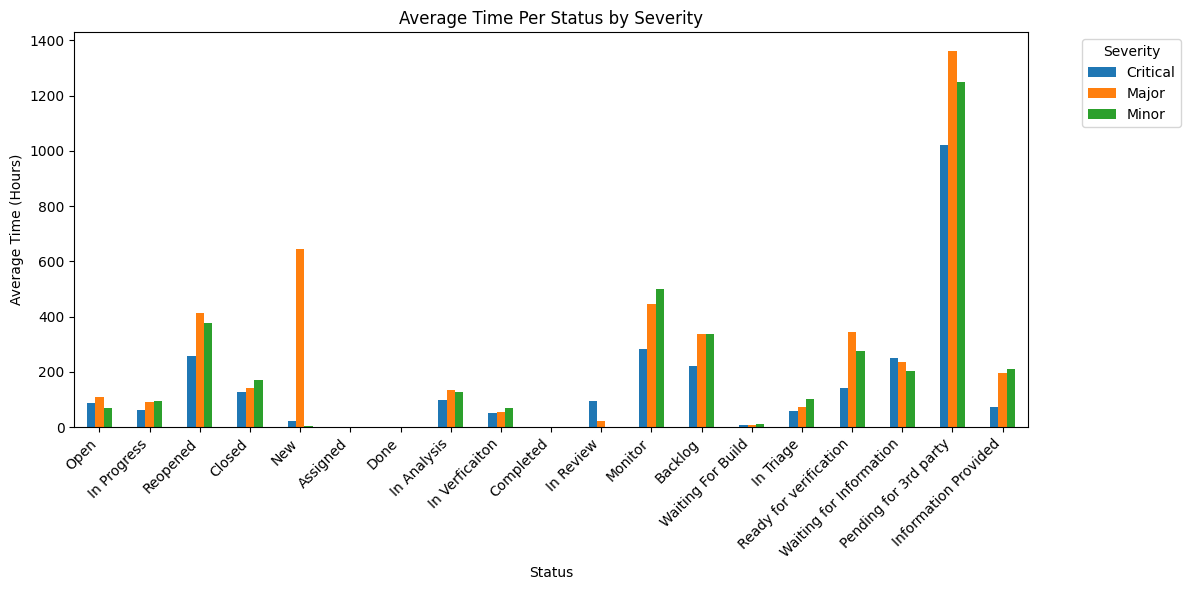

<Figure size 1200x600 with 0 Axes>

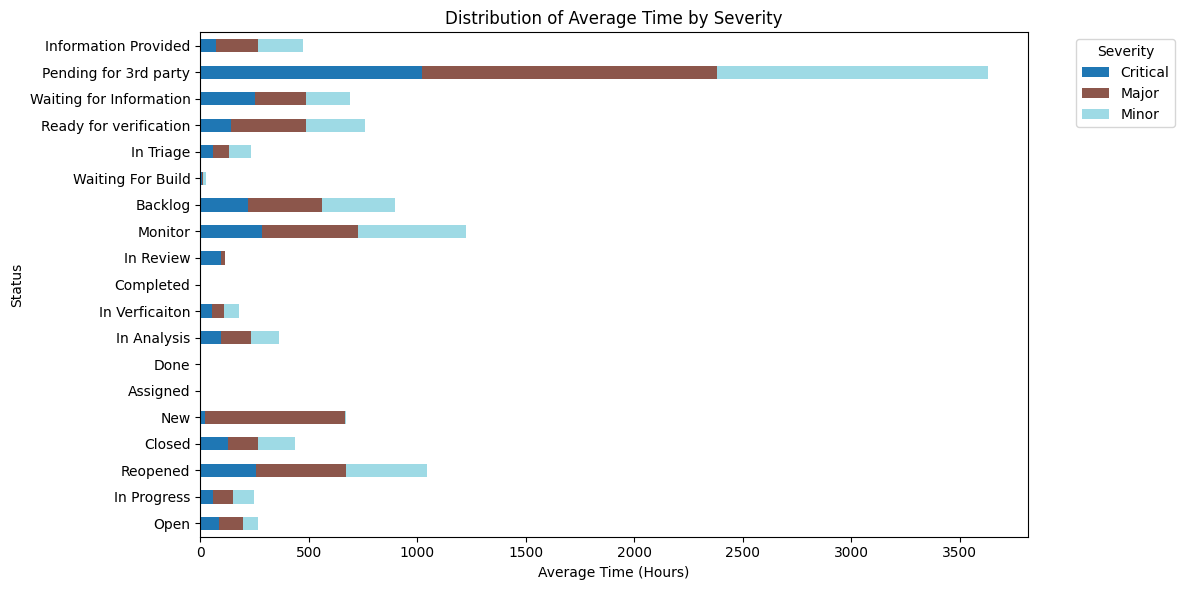

In [ ]:
# Filter the DataFrame to include only the relevant columns from the status mapping
relevant_columns = ['Severity'] + [status for status in status_mapping.values() if status in filtered_avg_time.columns]
filtered_avg_time_relevant = filtered_avg_time[relevant_columns]

# Transpose the DataFrame for plotting
transposed_data = filtered_avg_time_relevant.set_index('Severity').transpose()

# Bar Plot: Average time for each status by severity
plt.figure(figsize=(12, 6))
transposed_data.plot(kind='bar', figsize=(12, 6))
plt.title('Average Time Per Status by Severity')
plt.xlabel('Status')
plt.ylabel('Average Time (Hours)')
plt.legend(title='Severity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Stacked Bar Plot: Distribution of average times
plt.figure(figsize=(12, 6))
transposed_data.plot(kind='barh', stacked=True, figsize=(12, 6), colormap='tab20')
plt.title('Distribution of Average Time by Severity')
plt.xlabel('Average Time (Hours)')
plt.ylabel('Status')
plt.legend(title='Severity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

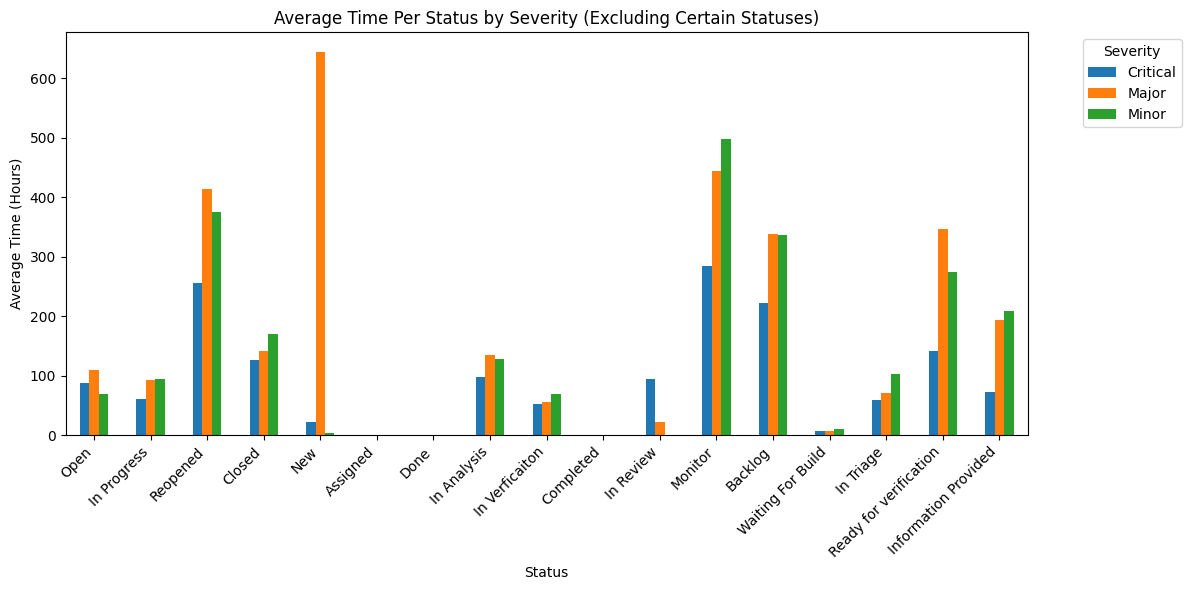

<Figure size 1200x600 with 0 Axes>

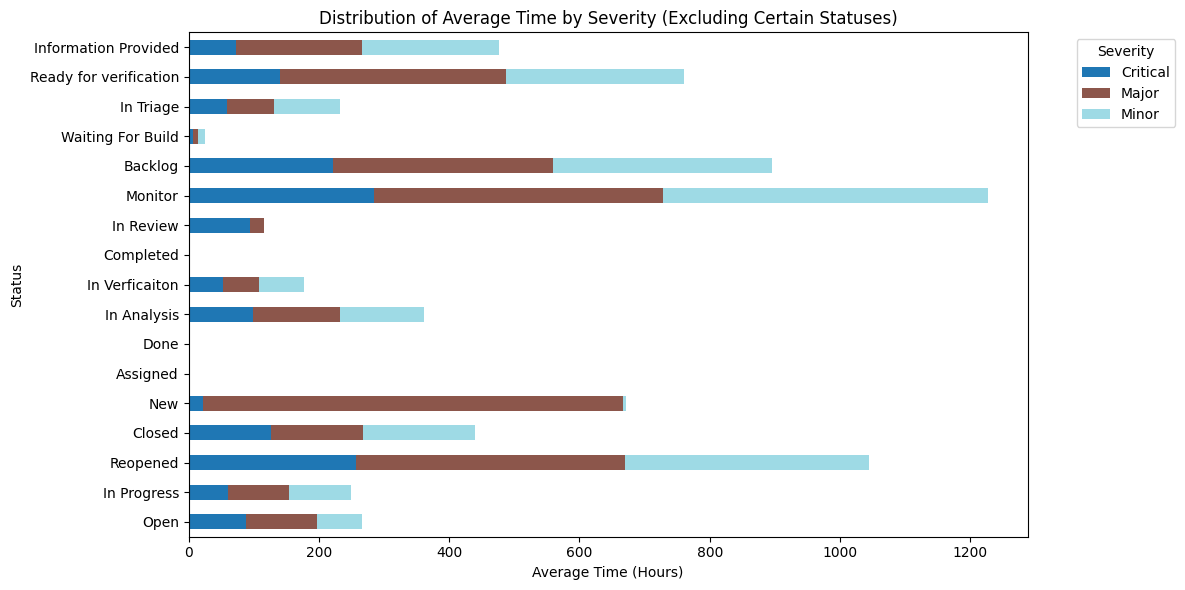

In [ ]:
# Remove 'Pending for 3rd party' and 'Waiting for Information' from relevant columns
filtered_columns_without_pending_waiting = [
    col for col in relevant_columns
    if col not in ['Pending for 3rd party', 'Waiting for Information']
]

# Filter the DataFrame to include the updated relevant columns
filtered_avg_time_relevant_without_pending_waiting = filtered_avg_time[filtered_columns_without_pending_waiting]

# Transpose the DataFrame for plotting
transposed_data_without_pending_waiting = filtered_avg_time_relevant_without_pending_waiting.set_index('Severity').transpose()

# Bar Plot: Average time for each status by severity
plt.figure(figsize=(12, 6))
transposed_data_without_pending_waiting.plot(kind='bar', figsize=(12, 6))
plt.title('Average Time Per Status by Severity (Excluding Certain Statuses)')
plt.xlabel('Status')
plt.ylabel('Average Time (Hours)')
plt.legend(title='Severity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Stacked Bar Plot: Distribution of average times
plt.figure(figsize=(12, 6))
transposed_data_without_pending_waiting.plot(kind='barh', stacked=True, figsize=(12, 6), colormap='tab20')
plt.title('Distribution of Average Time by Severity (Excluding Certain Statuses)')
plt.xlabel('Average Time (Hours)')
plt.ylabel('Status')
plt.legend(title='Severity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


##### The Number of times each status was assigned to a ticket

In [ ]:
times_assigned_df = pd.DataFrame(times_assigned_data.tolist())
times_assigned_df.columns = [f"status_id_{col}" for col in times_assigned_df.columns]
times_assigned_df.columns = [extract_and_map_status_name(col) for col in times_assigned_df.columns]
times_assigned_df

,Open,In Triage,In Progress,Waiting For Build,In Analysis,Backlog,In Verficaiton,Done,In Review,New,...,Information Provided,Reopened,Ready for verification,14726,34124,10219,5,40623,37724,37723
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7539,1.0,NaN,2.0,2.0,1.0,1.0,1.0,NaN,NaN,NaN,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7540,1.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7541,1.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7542,1.0,NaN,2.0,2.0,1.0,1.0,1.0,NaN,NaN,NaN,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Number of times each status was assigned more than once

In [ ]:
# Filter rows where any cell (excluding column 0) has a value greater than 1
# Filter rows where any cell has a value greater than 1.0
rows_with_values_greater_than_one = times_assigned_df[times_assigned_df.gt(1.0).any(axis=1)]

# Display the result
rows_with_values_greater_than_one

,Open,In Triage,In Progress,Waiting For Build,In Analysis,Backlog,In Verficaiton,Done,In Review,New,...,Information Provided,Reopened,Ready for verification,14726,34124,10219,5,40623,37724,37723
19,NaN,NaN,1.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,1.0,4.0,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83,1.0,NaN,NaN,NaN,3.0,1.0,1.0,NaN,NaN,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,1.0,NaN,1.0,NaN,1.0,1.0,2.0,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,1.0,NaN,1.0,1.0,2.0,1.0,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7536,2.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7537,1.0,2.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7539,1.0,NaN,2.0,2.0,1.0,1.0,1.0,NaN,NaN,NaN,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7542,1.0,NaN,2.0,2.0,1.0,1.0,1.0,NaN,NaN,NaN,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


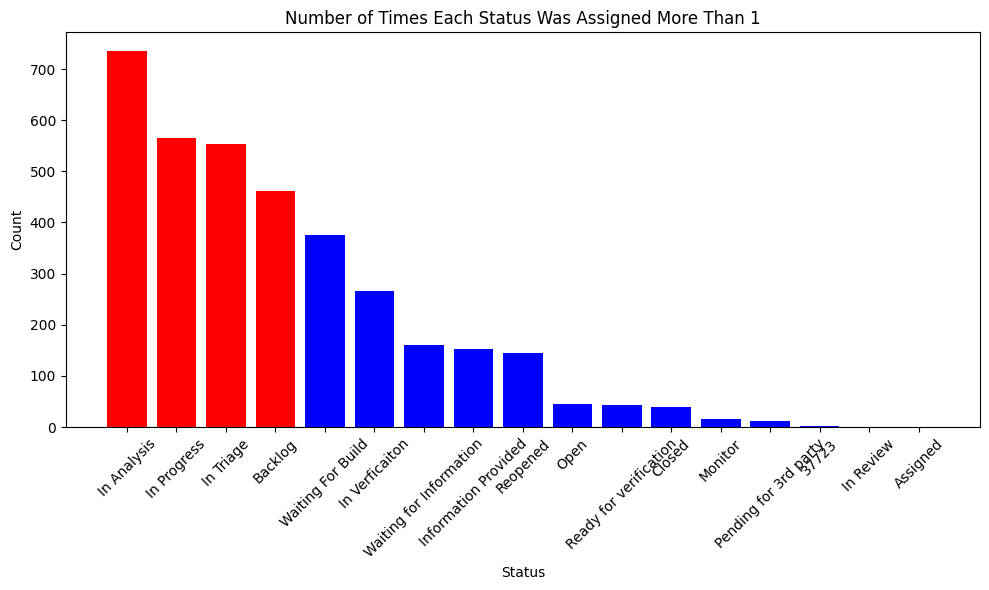

,Status,Count
0,In Analysis,735
1,In Progress,565
2,In Triage,554
3,Backlog,462
4,Waiting For Build,376
5,In Verficaiton,267
6,Waiting for Information,161
7,Information Provided,153
8,Reopened,145
9,Open,45


In [ ]:
status_counts = times_assigned_df[times_assigned_df.gt(1.0)].count()
status_counts = status_counts[status_counts > 0].sort_values(ascending=False)
status_table = status_counts.reset_index()
status_table.columns = ['Status', 'Count']

highlight_columns = ['In Analysis', 'In Progress', 'In Triage', 'Backlog']
colors = ['red' if status in highlight_columns else 'blue' for status in status_counts.index]
plt.figure(figsize=(10, 6))
bars = plt.bar(status_counts.index, status_counts.values, color=colors)
plt.title('Number of Times Each Status Was Assigned More Than 1')
plt.xlabel('Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

status_table

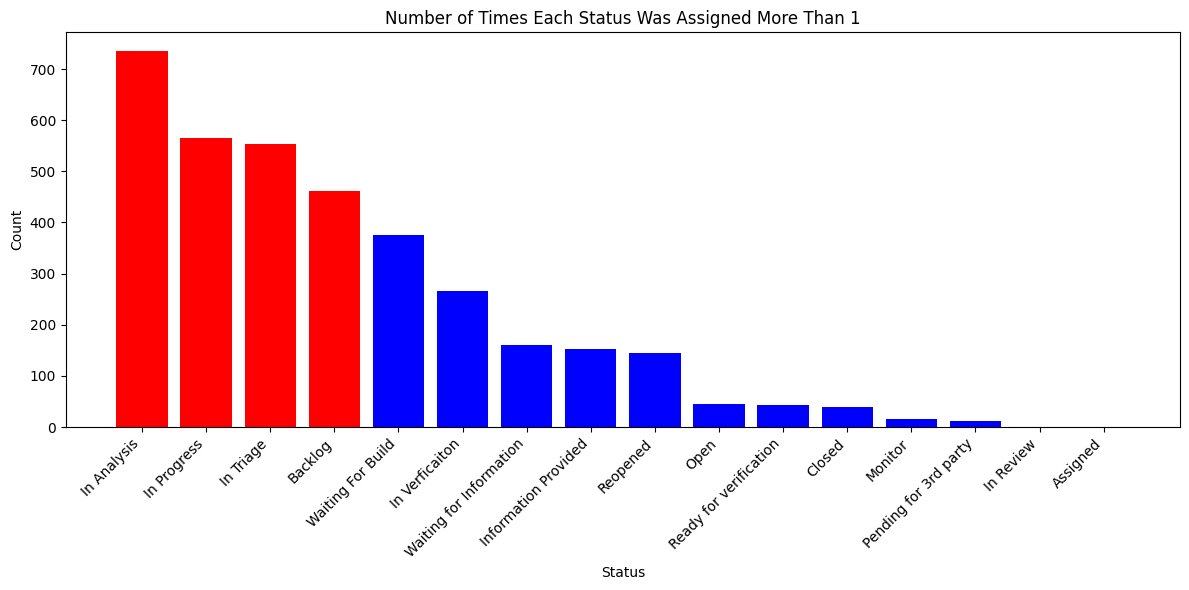

In [ ]:
status_counts = times_assigned_df[times_assigned_df.gt(1.0)].count()
status_counts = status_counts[status_counts > 0].sort_values(ascending=False)
status_table = status_counts.reset_index()
status_table.columns = ['Status', 'Count']
# Exclude "37723" from the data
status_counts_filtered = status_counts.drop('37723', errors='ignore')

# Adjust colors for the filtered data
highlight_columns = ['In Analysis', 'In Progress', 'In Triage', 'Backlog']
colors = ['red' if status in highlight_columns else 'blue' for status in status_counts_filtered.index]

# Create the plot with diagonally rotated x-axis labels
plt.figure(figsize=(12, 6))
bars = plt.bar(status_counts_filtered.index, status_counts_filtered.values, color=colors)

# Adjust the labels
plt.title('Number of Times Each Status Was Assigned More Than 1')
plt.xlabel('Status')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate labels diagonally with right alignment
plt.tight_layout()
plt.show()


## current status distribution

In [ ]:
# Sort the DataFrame by 'Issue_Key' and 'CREATED' to ensure proper chronological order
cl_df_sorted = cl_df.sort_values(by=['Issue_Key', 'CREATED'])

# Filter the rows where 'FIELD' is 'status'
status_cl_df = cl_df_sorted[cl_df_sorted['FIELD'] == 'status']

# Get the last status change for each ticket ('Issue_Key')
last_status_df = status_cl_df.groupby('Issue_Key').last().reset_index()

# Select relevant columns (Issue_Key and the latest NEWSTRING)
curr_status_df = last_status_df[['Issue_Key', 'NEWSTRING']]

# Display the resulting DataFrame
print(curr_status_df)

        Issue_Key        NEWSTRING
0        NCCFM-10           Closed
1       NCCFM-100           Closed
2     NCCFM-10000           Closed
3     NCCFM-10001           Closed
4     NCCFM-10002           Closed
...           ...              ...
7468   NCCFM-9994          Backlog
7469   NCCFM-9996           Closed
7470   NCCFM-9997           Closed
7471   NCCFM-9998  In Verification
7472   NCCFM-9999           Closed

[7473 rows x 2 columns]


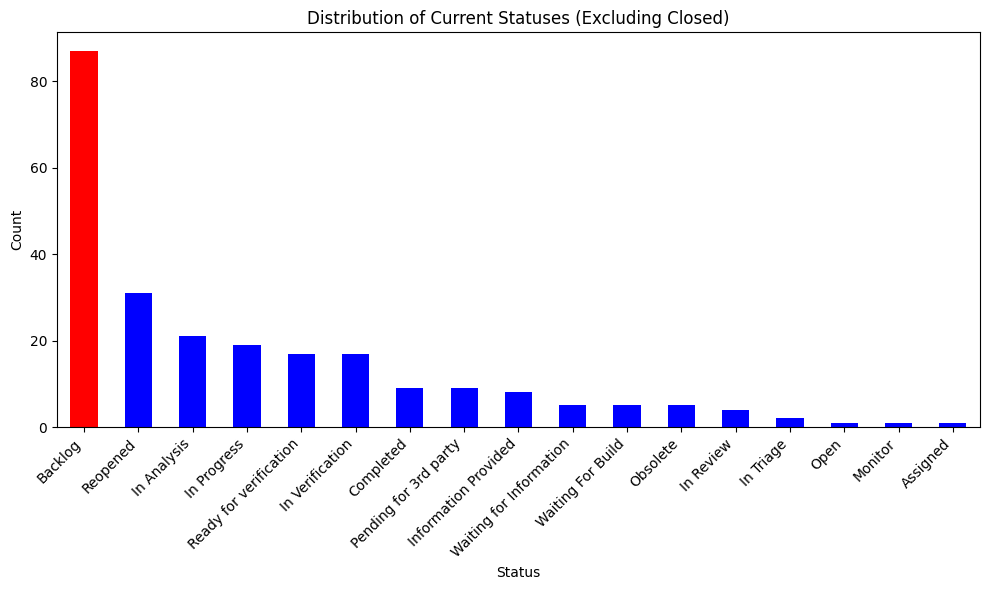

In [ ]:
# Process the data to calculate status counts
status_counts = curr_status_df['NEWSTRING'].value_counts()
# Filter out the 'Closed' status from the status counts
filtered_status_counts = status_counts[status_counts.index != 'Closed']
# Modify the colors to highlight "Backlog" in red
colors = ['red' if status == 'Backlog' else 'blue' for status in filtered_status_counts.index]

# Bar Chart Visualization with "Backlog" in red
plt.figure(figsize=(10, 6))
filtered_status_counts.plot(kind='bar', color=colors)
plt.title('Distribution of Current Statuses (Excluding Closed)')
plt.xlabel('Status')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the chart
plt.show()


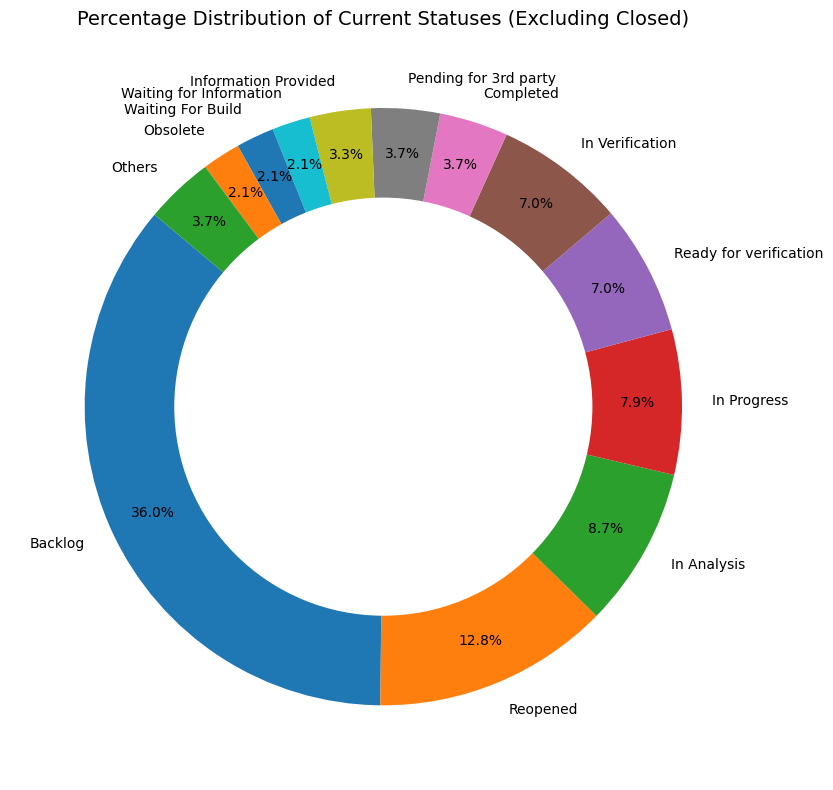

In [ ]:
# Filter out the 'Closed' status from the status counts
filtered_status_counts = status_counts[status_counts.index != 'Closed']

# Combine smaller slices into "Others" if they are less than a certain threshold (e.g., 2%)
threshold = 0.02 * filtered_status_counts.sum()  # 2% threshold
filtered_status_counts['Others'] = filtered_status_counts[filtered_status_counts < threshold].sum()
filtered_status_counts = filtered_status_counts[filtered_status_counts >= threshold]

# Improved Pie Chart Visualization
plt.figure(figsize=(10, 8))
filtered_status_counts.plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=140,
    pctdistance=0.85,  # Adjust the position of percentage labels
    textprops={'fontsize': 10}  # Adjust font size for better readability
)

# Add a title
plt.title('Percentage Distribution of Current Statuses (Excluding Closed)', fontsize=14)

# Draw a circle at the center to make it a donut chart
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
plt.gca().add_artist(centre_circle)

# Adjust layout for better readability
plt.ylabel('')  # Remove default ylabel
plt.tight_layout()

# Show the chart
plt.show()

In [ ]:
# Basic Statistics
status_counts = curr_status_df['NEWSTRING'].value_counts()

# Closed vs. Other statuses
closed_tickets = status_counts.get('Closed', 0)
non_closed_tickets = curr_status_df.shape[0] - closed_tickets

print(f"Out of {curr_status_df.shape[0]} tickets, {closed_tickets} are in 'Closed' status, and {non_closed_tickets} are in other statuses.")

Out of 7473 tickets, 7231 are in 'Closed' status, and 242 are in other statuses.


In [ ]:
# Count occurrences of each status in the entire DataFrame
status_counts = curr_status_df['NEWSTRING'].value_counts().reset_index()

# Rename columns for better clarity
status_counts.columns = ['Current Status', 'Count']

# Sort by count in descending order
status_counts = status_counts.sort_values(by='Count', ascending=False)

# Display the sorted table
status_counts

,Current Status,Count
0,Closed,7231
1,Backlog,87
2,Reopened,31
3,In Analysis,21
4,In Progress,19
5,Ready for verification,17
6,In Verification,17
7,Completed,9
8,Pending for 3rd party,9
9,Information Provided,8


## Team change distribution

In [ ]:
# Filter rows where the FIELD column is 'Team'
df_team = cl_df[cl_df['FIELD'] == 'Team']

# Count the number of team changes for each IssueId
team_changes_count = df_team.groupby('Issue_Key').size().reset_index(name='TeamChanges')

# Sort the data by TeamChanges in descending order
team_changes_count = team_changes_count.sort_values(by='TeamChanges', ascending=False)

team_changes_count.head(15)

,Issue_Key,TeamChanges
1282,NCCFM-2465,12
362,NCCFM-1135,11
733,NCCFM-1675,10
2571,NCCFM-434,9
2215,NCCFM-3795,9
3359,NCCFM-553,9
5782,NCCFM-946,8
4392,NCCFM-7179,8
587,NCCFM-1462,8
532,NCCFM-1375,8


In [ ]:
# Group by the 'TeamChanges' column and count occurrences
team_changes_distribution = team_changes_count.groupby('TeamChanges').size().reset_index(name='Count')

# Sort the result by 'TeamChanges' for better readability
team_changes_distribution = team_changes_distribution.sort_values(by='TeamChanges', ascending=True)

# Display the resulting DataFrame
team_changes_distribution

,TeamChanges,Count
0,1,4241
1,2,1046
2,3,527
3,4,128
4,5,68
5,6,22
6,7,8
7,8,6
8,9,3
9,10,1


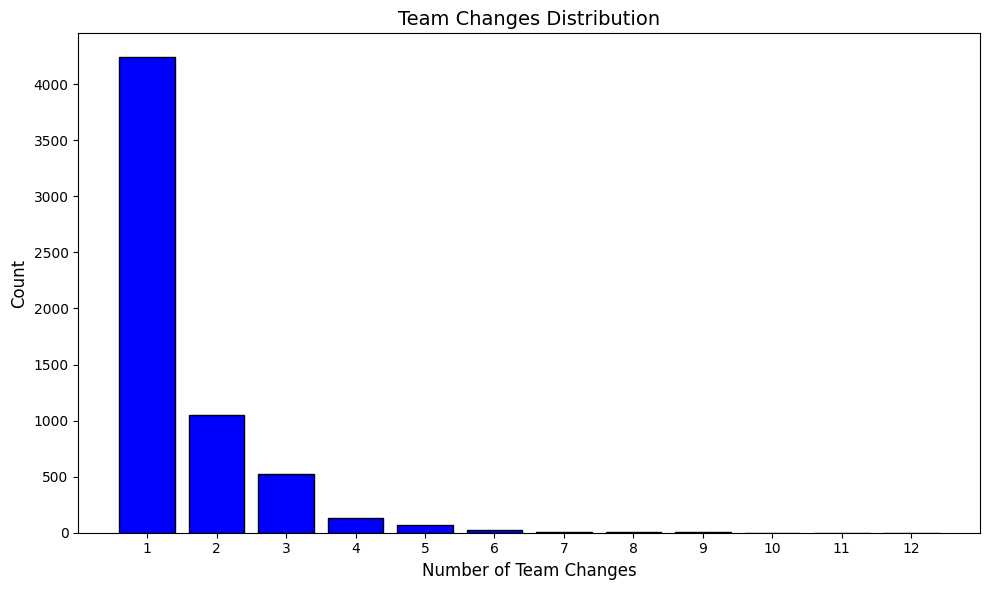

In [ ]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(team_changes_distribution['TeamChanges'], team_changes_distribution['Count'], color='blue', edgecolor='black')
plt.title('Team Changes Distribution', fontsize=14)
plt.xlabel('Number of Team Changes', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(team_changes_distribution['TeamChanges'], fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

## Teams vs Status

In [ ]:
# Get the unique Issue IDs from the original data and the filtered data
all_issues = cl_df['Issueid'].unique()
issues_with_team_changes = df_team['Issueid'].unique()

# Calculate the number of issues without team changes
issues_without_team_changes_count = len(set(all_issues) - set(issues_with_team_changes))

issues_without_team_changes_count

1472

In [ ]:
#Exclude rows where the old team and the new team are the same
df_team = df_team[df_team['OLDSTRING'] != df_team['NEWSTRING']]

#Sort by Issue_Key and CREATED to ensure chronological order
df_team = df_team.sort_values(by=['Issue_Key', 'CREATED'])

#Calculate the end time as the next CREATED time for the same Issue_Key
df_team['End_Time'] = df_team.groupby('Issue_Key')['CREATED'].shift(-1)

# Calculate the time difference in minutes between Start_Time and End_Time
df_team['Time_Difference'] = (
    pd.to_datetime(df_team['End_Time']) - pd.to_datetime(df_team['CREATED'])
).dt.total_seconds() / 60

#Select relevant columns for the new DataFrame
df_team_summary = df_team[['Issue_Key', 'OLDSTRING', 'NEWSTRING', 'CREATED', 'End_Time', 'Time_Difference']].copy()

#Rename columns for better clarity
df_team_summary.columns = ['Issue_Key', 'Old_Team', 'New_Team', 'Start_Time', 'End_Time', 'Time_Difference_in_Minutes']

#Display the resulting DataFrame
print(df_team_summary)

         Issue_Key Old_Team           New_Team          Start_Time  \
24197     NCCFM-10    Exalt             SPS UI 2022-06-15 18:21:43   
24196     NCCFM-10   SPS UI             Enigma 2022-09-12 09:48:12   
24198     NCCFM-10   Enigma                NaN 2023-03-07 16:12:39   
24194     NCCFM-10      NaN             SPS UI 2023-03-07 16:45:59   
24195     NCCFM-10   SPS UI             Enigma 2023-03-07 18:59:54   
...            ...      ...                ...                 ...   
178517   NCCFM-999      NaN  SPS Documentation 2022-09-13 20:28:12   
178518  NCCFM-9990      NaN             Austin 2024-09-24 22:57:34   
178519  NCCFM-9997      NaN             Austin 2024-09-18 18:12:50   
178520  NCCFM-9998      NaN     SPS Charging 3 2024-09-12 18:11:28   
178521  NCCFM-9999      NaN        Matrix Team 2024-09-26 12:18:44   

                  End_Time  Time_Difference_in_Minutes  
24197  2022-09-12 09:48:12               127646.483333  
24196  2023-03-07 16:12:39               2538

In [ ]:
# Filter rows where 'Old_Team' contains 'CCoE' and 'New_Team' does not contain 'CCoE'
ccoe_to_non_ccoe_count = df_team_summary[
    (df_team_summary['Old_Team'].str.contains('CCoE', na=False)) &
    (~df_team_summary['New_Team'].str.contains('CCoE', na=False))
].shape[0]

ccoe_to_non_ccoe_count

241

## CheckIn's in keys with mor than 3 team change

In [ ]:
# Identify all columns that start with "Comment"
comment_columns = [col for col in comments_data.columns if col.startswith("Comment")]

# Concatenate all comments into a single column for each issue
comments_data['All_Comments'] = comments_data[comment_columns].fillna('').agg(' '.join, axis=1)


team_changes_count = pd.DataFrame(team_changes_count)
filtered_keys = team_changes_count[team_changes_count['TeamChanges'] > 3]['Issue_Key']

# Filter comments for the relevant Issue Keys
filtered_comments = comments_data[comments_data['Key'].isin(filtered_keys)]

# Check for occurrences of "gerrit" or "git"
filtered_comments['CheckInCount'] = filtered_comments['All_Comments'].str.contains(r'\bgerrit\b|\bgit\b', case=False, na=False).astype(int)

# Summarize results
check_in_summary = filtered_comments.groupby('Key')['CheckInCount'].sum().reset_index()

# Display the results
check_in_summary = check_in_summary.sort_values(by='CheckInCount', ascending=False).reset_index(drop=True)
check_in_summary

,Key,CheckInCount
0,NCCFM-10,1
1,NCCFM-338,1
2,NCCFM-505,1
3,NCCFM-5157,1
4,NCCFM-5174,1
...,...,...
233,NCCFM-2123,0
234,NCCFM-2186,0
235,NCCFM-2209,0
236,NCCFM-2257,0


# Model - Part 2

In [ ]:
pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 747.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
df = df_raw

In [ ]:
from sentence_transformers import SentenceTransformer
import pandas as pd

# טען את המודל
model = SentenceTransformer('all-MiniLM-L6-v2')

# נניח שיש לך עמודת תיאור תקלות
texts = df['fields.description'].fillna('').tolist()

# הפקת embedding לכל תיאור
embeddings = model.encode(texts, show_progress_bar=True)

# החזרה לתוך הדאטה
import numpy as np
df['embedding'] = list(embeddings)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/236 [00:00<?, ?it/s]

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split

# המרת embedding ל־numpy array
X = np.vstack(df['embedding'].values)

# קידוד הצוותים המטפלים
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['fields.Team .name'])

# המרת numpy ל־Torch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# יצירת DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class TeamClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(TeamClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.drop1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, 128)
        self.drop2 = nn.Dropout(0.3)
        self.output = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        return self.output(x)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TeamClassifier(input_dim=X.shape[1], num_classes=len(label_encoder.classes_)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# לולאת אימון
for epoch in range(10):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


In [ ]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for batch_X, batch_y in val_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

print(f"Accuracy on validation set: {100 * correct / total:.2f}%")


In [ ]:
torch.save(model.state_dict(), "team_classifier.pt")